# Implementation of Boosting Support Vector Machines

In [60]:
# Libraries
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Classifier class

In [61]:
class BoostingSVM:
    def __init__(self, x=None,y=None, sigma_ini = 50, sigma_min = 10, sigma_step = 0.5):
        """
        This is a custom implementation of the Boosting SVM algorithm. It is based 
        on the combination of Adaboost and RFB SVM weak learners. To create the model,
        this class needs the following inputs:
        
        X_train: Training features. Size N x D
        y_train: Training labels. Size N x 1

        """
        self.sigma_ini = sigma_ini
        self.sigma_step = sigma_step
        self.sigma_min = sigma_min
    
    def fit(self,X_train,y_train):
        sigma = self.sigma_ini 
        
        # Initialize weights
        number_samples = np.shape(X_train)[0]
        weights = np.ones(number_samples)/number_samples
        
        # Define vectors to store weak predictors and significances of each iteration
        self.weak_learners = [] #np.zeros(shape=self.number_iterations, dtype=object)
        self.significance_vec = [] #np.zeros(shape=self.number_iterations)
        self.error_debug = []
        
        # Todo: Apply dimensionality reduction
        self.pca = PCA(n_components = 2).fit(X_train)
        self.variance_explained = pca.explained_variance_ratio_
        X_train = self.pca.fit_transform(X_train)
        
        #for iterations in range(self.number_iterations):
        while sigma > self.sigma_min:
            print('Sigma: %.1f' % sigma)
            #print('BoostSVM iteration: %d' % (iterations))
            current_weights = weights
            
            # Create and save week learner for this iteration
            weak_learner = SVC(kernel='rbf', gamma = 1/2/sigma**2) #SVC(max_iter=10,tol=5)
            weak_learner_model = weak_learner.fit(X_train, y_train, sample_weight=current_weights)

            # The new weak learner model is saved
            weak_learner_pred = weak_learner_model.predict(X_train)
            
            # Calculate error
            error = np.sum(current_weights[np.where(weak_learner_pred != y_train)[0]]) 
            self.error_debug.append(error)
            
            if error > 0.5:
                sigma = sigma - self.sigma_step
            else:
                # Significance of the weak learner model is calculated and saved
                significance = 0.5*np.log((1-error)/error) 
                self.significance_vec.append(significance)
                self.weak_learners.append(weak_learner_model)

                # Update weights for each sample
                idx_incorrect = np.where(weak_learner_pred != y_train)[0]
                idx_correct = np.where(weak_learner_pred == y_train)[0]
                weights[idx_incorrect] = np.multiply(current_weights[idx_incorrect],np.exp(significance))
                weights[idx_correct] = current_weights[idx_correct]*np.exp(-significance)

                # Normalize weights
                weights /= weights.sum()
        
    def predict(self,X_test):
        X_test_pca = self.pca.fit_transform(X_test)
        model_preds = np.array([model.predict(X_test_pca) for model in self.weak_learners])
        y_test_pred = np.sign(np.dot(self.significance_vec, model_preds))
        return y_test_pred.astype(int)

## Testing

In [62]:
# Load data
data = pd.read_pickle("./data_no_cathegorical.pkl")

X = data.values[:,:-1]
Y = data.values[:,-1]

# Split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

In [66]:
# Create models
classifierSVM = SVC()
#classifierBoostSVM = BoostingSVM()
#classifierAda = AdaBoostClassifier(n_estimators=100)

classifierSVM.fit(X_train, y_train)
print('VSC - OK')
#classifierBoostSVM.fit(X_train, y_train)
#print('BoostSVM - OK')
#classifierAda.fit(X_train, y_train)
#print('AdaBoost - OK')

SVMpredictions = classifierSVM.predict(X_test)
#BoostSVMpredictions = classifierBoostSVM.predict(X_test)
#Adapredictions = classifierAda.predict(X_test)

print('Accuracy with default SVM:      %.4f' % (len(np.where(y_test==SVMpredictions)[0])/len(y_test)))
#print('Accuracy with our Boosting SVM: %.4f' % (len(np.where(y_test==BoostSVMpredictions)[0])/len(y_test)))
#print('Accuracy with AdaBoost:         %.4f' % (len(np.where(y_test==Adapredictions)[0])/len(y_test)))

VSC - OK
Accuracy with default SVM:      0.7348


In [64]:
BoostSVMpredictions = classifierBoostSVM.predict(X_test)
#Adapredictions = classifierAda.predict(X_test)

#print('Accuracy with default SVM:      %.4f' % (len(np.where(y_test==SVMpredictions)[0])/len(y_test)))
print('Accuracy with our Boosting SVM: %.4f' % (len(np.where(y_test==BoostSVMpredictions)[0])/len(y_test)))
#print('Accuracy with AdaBoost:         %.4f' % (len(np.where(y_test==Adapredictions)[0])/len(y_test)))

Accuracy with our Boosting SVM: 0.7343


In [58]:
x_test_pca = classifierBoostSVM.pca.fit_transform(X_test)
model_preds = np.array([model.predict(x_test_pca) for model in classifierBoostSVM.weak_learners])
y_test_pred = np.sign(np.dot(classifierBoostSVM.significance_vec, model_preds))

ValueError: shapes (2,) and (200,9729) not aligned: 2 (dim 0) != 200 (dim 0)

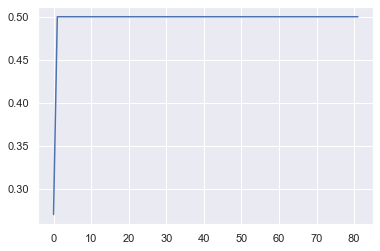

In [65]:
plt.figure()
plt.plot(classifierBoostSVM.error_debug)

## Considering the option of dimension reduction to speed-up SVM boosting.

[9.98720996e-01 7.70519718e-04]
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


Text(0.5, 1.0, 'PCA')

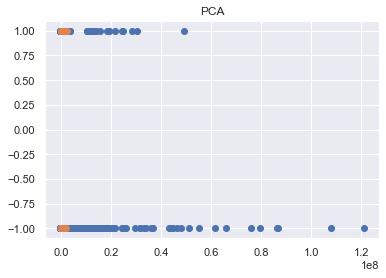

In [48]:
# SVM is very slow as it is computationally expensive. 
# We will try to extract the most significant features to speed-up the algorithm

# PCA
pca = PCA(n_components = 2).fit(X_train)
print(pca.explained_variance_ratio_)
print(pca)
Xnew_pca= pca.fit_transform(X_train)

plt.figure()
plt.plot(Xnew,y_train,'o')
plt.title('PCA') 

# LDA
#lda = LDA(n_components = 1)
#Xnew_lda = lda.fit_transform(X_train, y_train)

#plt.figure()
#plt.plot(Xnew_lda,y_train.resha,'o')
#plt.title('LDA')

# We choose PCA!

In [42]:
Xnew_lda.shape

(19750, 1)